In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"monkrld","key":"ea52c98eb19cb43a1c00e3e61f3c64dd"}'}

Install the kaggle API

In [ ]:
!pip install -q kaggle

Moving the kaggle.json file into ~/.kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!cp kaggle.json ~/.kaggle/

Downloading files

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -p '/content'

100% 23.1G/23.1G [03:24<00:00, 140MB/s]
100% 23.1G/23.1G [03:24<00:00, 121MB/s]


In [ ]:
!unzip -q '/content/fashion-product-images-dataset.zip'

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
#from transformers import CLIPTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
import sys

project_path = '/content/drive/MyDrive/Github/Product-image-generation-from-text-description'
sys.path.insert(0, project_path)

from CustomDataset import CustomTensorDataset

Preprocessing

In [ ]:
# Load the tokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 13.2 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from diffusers import AutoencoderKL 
from diffusers import UNet2DConditionModel, LMSDiscreteScheduler, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    
def disable_grad(model):
    for p in model.parameters(): 
        p.requires_grad = False 
        
    return model

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

Reading descriptions

In [12]:
import os

path_to_descriptions = os.path.join(project_path, 'descriptions.json')
descriptions = pd.read_json(path_to_descriptions, orient='records')

In [ ]:
RESOLUTION = 256

data_transformation_images = transforms.Compose([
            transforms.Resize((RESOLUTION, RESOLUTION)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ])

path = '/content/fashion-dataset/images'
batch_size = 32

dataset = CustomTensorDataset(descriptions, tokenizer, path, transform_images=data_transformation_images)

TrainTest split

In [ ]:
indices = np.arange(len(descriptions))
indices_train, indices_test = train_test_split(indices, test_size=0.2)

Creating train_dataset, test_dataset and train_loader, test_loader

In [ ]:
train_dataset = Subset(dataset, indices_train)
test_dataset = Subset(dataset, indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#next(iter(test_loader))

In [ ]:
ids = [3, 4, 7]
text_prompts = [prompt for prompt in descriptions.iloc[[3, 4, 7], :]['description'].values]
print(text_prompts)

['Men Black Dial Chronograph Watch FS Winter Casual Accessories', 'Silver Ring Fall Casual', 'Women Yacho Jhuti Pink Belt Winter Casual Accessories']


In [ ]:
def generate_images(text_prompts, vae, unet, noise_scheduler, text_encoder, tokenizer, im_height=512, im_width=512):
    noise_scheduler.set_timesteps(70)
    text = [tokenizer(text_prmt, padding="max_length", 
                                max_length=tokenizer.model_max_length, truncation=True,
                                return_tensors="pt")["input_ids"] for text_prmt in text_prompts]
    text = torch.cat(text)#.half()
    batch_size = text.shape[0]

    with torch.no_grad():
        text_embeddings = text_encoder(text.to(device))[0].half()

    latents = torch.randn((batch_size, unet.in_channels, im_height // 8, im_width // 8))
    latents = latents.half().to(device) #* noise_scheduler.init_noise_sigma
    latents = latents * vae.config.scaling_factor 

    for t in noise_scheduler.timesteps:
        latent_model_input = noise_scheduler.scale_model_input(latents, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    latents = 1 / vae.config.scaling_factor * latents

    with torch.no_grad():
        images = vae.decode(latents).sample

    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    return images

In [ ]:
links = {}
for file in os.listdir(path):
    links[int(file.split('.')[0])] = path + '/' + file

In [ ]:
images = generate_images(text_prompts, vae, unet, noise_scheduler, text_encoder, tokenizer)

In [13]:
links = {}
path = '/content/fashion-dataset/images'

for file in os.listdir(path):
    links[int(file.split('.')[0])] = path + '/' + file

In [18]:
idx = descriptions.iloc[[3, 4, 7]]['id']

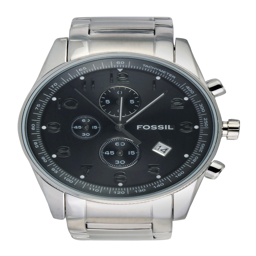

In [25]:
from PIL import Image

Image.open(links[idx[3]]).resize((256, 256))

Text(0.5, 1.0, 'Men Black Dial Chronograph Watch FS Winter Casual Accessories')

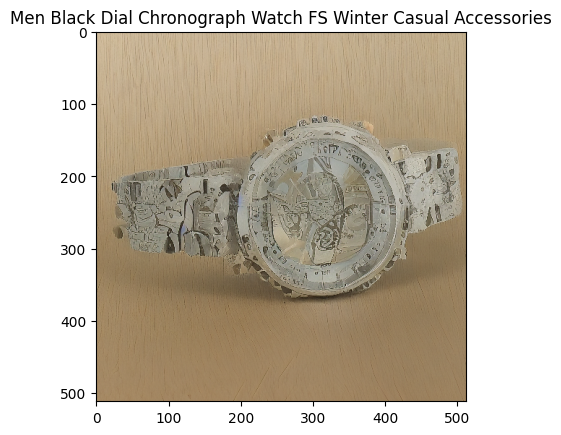

In [ ]:
import matplotlib.pyplot as plt

plt.imshow((images * 255).astype("uint")[0])
plt.title(text_prompts[0])

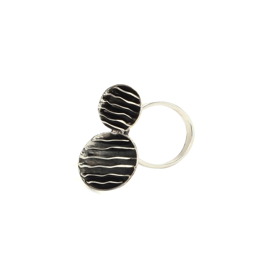

In [26]:
Image.open(links[idx[4]]).resize((256, 256))

Text(0.5, 1.0, 'Silver Ring Fall Casual')

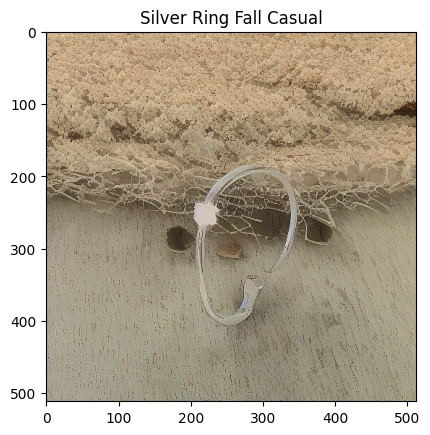

In [ ]:
plt.imshow((images * 255).astype("uint")[1])
plt.title(text_prompts[1])

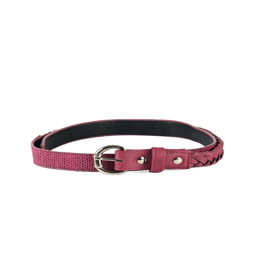

In [27]:
Image.open(links[idx[7]]).resize((256, 256))

Text(0.5, 1.0, 'Women Yacho Jhuti Pink Belt Winter Casual Accessories')

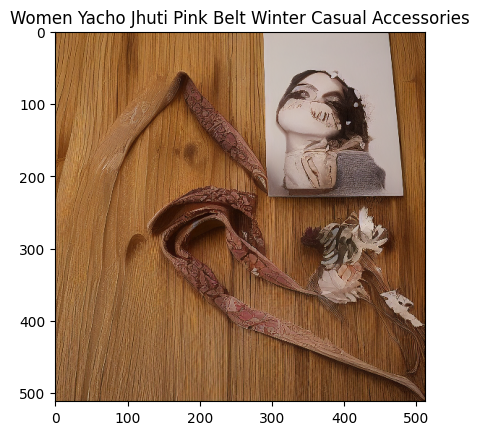

In [ ]:
plt.imshow((images * 255).astype("uint")[2])
plt.title(text_prompts[2])